In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from torchvision import models, transforms

In [ ]:

class MultiDayDataset(Dataset):
    def __init__(self, image_paths, irradiance_values, target_size=(224,224)):
        self.image_paths = image_paths
        self.irradiance_values = irradiance_values
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img)
        irradiance = torch.tensor(self.irradiance_values[idx], dtype=torch.float32)
        return img_tensor, irradiance

def get_multi_day_dataset(image_dirs, irradiance_files):
    image_paths = []
    irradiance_values = []
    for img_dir, irr_file in zip(image_dirs, irradiance_files):
        if irr_file.endswith('.csv'):
            df = pd.read_csv(irr_file)
            values = df.iloc[:, 1].values.astype(np.float32)
        else:
            values = np.loadtxt(irr_file, delimiter=',')[:, 1].astype(np.float32)

        files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        files = files[:len(values)]
        image_paths.extend([os.path.join(img_dir, f) for f in files])
        irradiance_values.extend(values[:len(files)])
    return MultiDayDataset(image_paths, irradiance_values)

In [ ]:
class EfficientNetRegression(nn.Module):
    def __init__(self, num_classes=1, model_name='efficientnet_b0', pretrained=True):
        super(EfficientNetRegression, self).__init__()
        if pretrained:
            weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        else:
            weights = None
        backbone = getattr(models, model_name)(weights=weights)
        self.features = backbone.features
        self.pooling = nn.AdaptiveAvgPool2d(1)
        in_features = backbone.classifier[1].in_features
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = self.regressor(x)
        return x

In [ ]:
class CNNTrainer:
    def __init__(self, config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.config = {
            'learning_rate': 1e-4,
            'batch_size': 64,
            'num_epochs': 20,
            'weight_decay': 1e-4,
            'scheduler_patience': 5,
            'early_stopping_patience': 10,
            'save_dir': 'models',
            'log_dir': 'logs'
        }
        if config:
            self.config.update(config)
        os.makedirs(self.config['save_dir'], exist_ok=True)
        os.makedirs(self.config['log_dir'], exist_ok=True)
        self.model = EfficientNetRegression().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.config['learning_rate'],
                                    weight_decay=self.config['weight_decay'])
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                             mode='min',
                                                             patience=self.config['scheduler_patience'],
                                                             factor=0.5)
        self.criterion = nn.MSELoss()
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        with tqdm(train_loader, desc="Training") as pbar:
            for images, targets in pbar:
                images, targets = images.to(self.device), targets.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), targets)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        predictions, targets_all = [], []
        with torch.no_grad():
            with tqdm(val_loader, desc="Validation") as pbar:
                for images, targets in pbar:
                    images, targets = images.to(self.device), targets.to(self.device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs.squeeze(), targets)
                    total_loss += loss.item()
                    predictions.extend(outputs.squeeze().cpu().numpy())
                    targets_all.extend(targets.cpu().numpy())
                    pbar.set_postfix({'Val Loss': f'{loss.item():.4f}'})
        avg_loss = total_loss / len(val_loader)
        predictions = np.array(predictions)
        targets_all = np.array(targets_all)
        rmse = np.sqrt(mean_squared_error(targets_all, predictions))
        mae = mean_absolute_error(targets_all, predictions)
        return avg_loss, rmse, mae

    def train(self, train_loader, val_loader):
        print(f"Starting training for {self.config['num_epochs']} epochs...")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        for epoch in range(self.config['num_epochs']):
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']}")
            train_loss = self.train_epoch(train_loader)
            self.train_losses.append(train_loss)
            print(f"Train Loss: {train_loss:.4f}")
            val_loss, rmse, mae = self.validate_epoch(val_loader)
            self.val_losses.append(val_loss)
            print(f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
            self.scheduler.step(val_loss)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                    'config': self.config
                }, os.path.join(self.config['save_dir'], 'best_efficientnet_model.pth'))
                print(f"New best model saved!")
            else:
                self.patience_counter += 1
            if self.patience_counter >= self.config['early_stopping_patience']:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        plt.figure(figsize=(10,6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('EfficientNet Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()

Loading multi-day dataset...
Train samples: 8133, Val samples: 2034
Using device: cuda
Starting training for 25 epochs...
Model parameters: 4,368,509

Epoch 1/25


Training: 100%|██████████| 128/128 [15:12<00:00,  7.13s/it, Loss=11423.1172]


Train Loss: 23058.3705


Validation: 100%|██████████| 32/32 [03:38<00:00,  6.84s/it, Val Loss=6146.8145]


Val Loss: 5151.3662, RMSE: 71.73, MAE: 45.12
New best model saved!

Epoch 2/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=4563.4434]


Train Loss: 3345.3037


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s, Val Loss=2062.5825]


Val Loss: 1617.4907, RMSE: 40.18, MAE: 25.65
New best model saved!

Epoch 3/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=2611.5642]


Train Loss: 1656.4529


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s, Val Loss=1758.6205]


Val Loss: 1086.7600, RMSE: 32.90, MAE: 20.19
New best model saved!

Epoch 4/25


Training: 100%|██████████| 128/128 [01:09<00:00,  1.85it/s, Loss=4684.5635]


Train Loss: 1404.4609


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s, Val Loss=1287.0304]


Val Loss: 1042.9041, RMSE: 32.27, MAE: 16.83
New best model saved!

Epoch 5/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=1784.9603]


Train Loss: 1117.2431


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s, Val Loss=838.7492]


Val Loss: 786.7310, RMSE: 28.04, MAE: 16.65
New best model saved!

Epoch 6/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.87it/s, Loss=1900.8118]


Train Loss: 953.1396


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s, Val Loss=567.3674]


Val Loss: 828.6182, RMSE: 28.82, MAE: 15.82

Epoch 7/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=2303.0261]


Train Loss: 868.3764


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s, Val Loss=1119.0924]


Val Loss: 585.1084, RMSE: 24.11, MAE: 12.45
New best model saved!

Epoch 8/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.87it/s, Loss=1854.8245]


Train Loss: 893.1186


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s, Val Loss=1231.6091]


Val Loss: 640.3831, RMSE: 25.23, MAE: 12.94

Epoch 9/25


Training: 100%|██████████| 128/128 [01:07<00:00,  1.88it/s, Loss=6686.9673]


Train Loss: 719.6908


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s, Val Loss=954.2781]


Val Loss: 607.7834, RMSE: 24.60, MAE: 14.60

Epoch 10/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.87it/s, Loss=488.1289]


Train Loss: 612.6170


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.05it/s, Val Loss=628.5039]


Val Loss: 402.2573, RMSE: 20.02, MAE: 12.63
New best model saved!

Epoch 11/25


Training: 100%|██████████| 128/128 [01:11<00:00,  1.80it/s, Loss=8285.1738]


Train Loss: 541.9784


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s, Val Loss=376.0050]


Val Loss: 307.3099, RMSE: 17.52, MAE: 9.69
New best model saved!

Epoch 12/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.87it/s, Loss=5383.9111]


Train Loss: 518.4032


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s, Val Loss=475.0430]


Val Loss: 322.1615, RMSE: 17.92, MAE: 10.20

Epoch 13/25


Training: 100%|██████████| 128/128 [01:09<00:00,  1.84it/s, Loss=1131.7804]


Train Loss: 375.7163


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s, Val Loss=247.0217]


Val Loss: 415.9684, RMSE: 20.42, MAE: 12.54

Epoch 14/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=670.4836]


Train Loss: 359.2313


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s, Val Loss=229.1128]


Val Loss: 409.9537, RMSE: 20.28, MAE: 9.90

Epoch 15/25


Training: 100%|██████████| 128/128 [01:09<00:00,  1.85it/s, Loss=399.2250]


Train Loss: 338.7957


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s, Val Loss=364.4642]


Val Loss: 278.6509, RMSE: 16.68, MAE: 9.26
New best model saved!

Epoch 16/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.87it/s, Loss=3948.4355]


Train Loss: 378.8451


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s, Val Loss=220.8735]


Val Loss: 271.9198, RMSE: 16.50, MAE: 8.68
New best model saved!

Epoch 17/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=332.3098]


Train Loss: 334.7844


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s, Val Loss=285.4795]


Val Loss: 253.4229, RMSE: 15.91, MAE: 10.01
New best model saved!

Epoch 18/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.88it/s, Loss=164.9445]


Train Loss: 302.5613


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s, Val Loss=286.9248]


Val Loss: 279.2348, RMSE: 16.71, MAE: 9.49

Epoch 19/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.86it/s, Loss=88.6259]


Train Loss: 259.6814


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s, Val Loss=835.0784]


Val Loss: 233.2191, RMSE: 15.14, MAE: 7.55
New best model saved!

Epoch 20/25


Training: 100%|██████████| 128/128 [01:07<00:00,  1.89it/s, Loss=3977.9844]


Train Loss: 298.9243


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s, Val Loss=795.3265]


Val Loss: 455.4898, RMSE: 21.29, MAE: 9.44

Epoch 21/25


Training: 100%|██████████| 128/128 [01:07<00:00,  1.89it/s, Loss=1500.7094]


Train Loss: 332.0053


Validation: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s, Val Loss=879.9987]


Val Loss: 339.1733, RMSE: 18.32, MAE: 10.37

Epoch 22/25


Training: 100%|██████████| 128/128 [01:07<00:00,  1.88it/s, Loss=229.4739]


Train Loss: 284.6239


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s, Val Loss=1760.7184]


Val Loss: 968.8498, RMSE: 31.04, MAE: 13.52

Epoch 23/25


Training: 100%|██████████| 128/128 [01:08<00:00,  1.87it/s, Loss=286.2125]


Train Loss: 301.4969


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s, Val Loss=208.6927]


Val Loss: 248.6608, RMSE: 15.78, MAE: 8.58

Epoch 24/25


Training: 100%|██████████| 128/128 [01:07<00:00,  1.89it/s, Loss=256.1610]


Train Loss: 262.4073


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s, Val Loss=794.8262]


Val Loss: 344.3138, RMSE: 18.47, MAE: 7.79

Epoch 25/25


Training: 100%|██████████| 128/128 [01:07<00:00,  1.88it/s, Loss=6372.3730]


Train Loss: 344.3787


Validation: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s, Val Loss=718.7260]


Val Loss: 261.6005, RMSE: 16.08, MAE: 8.10


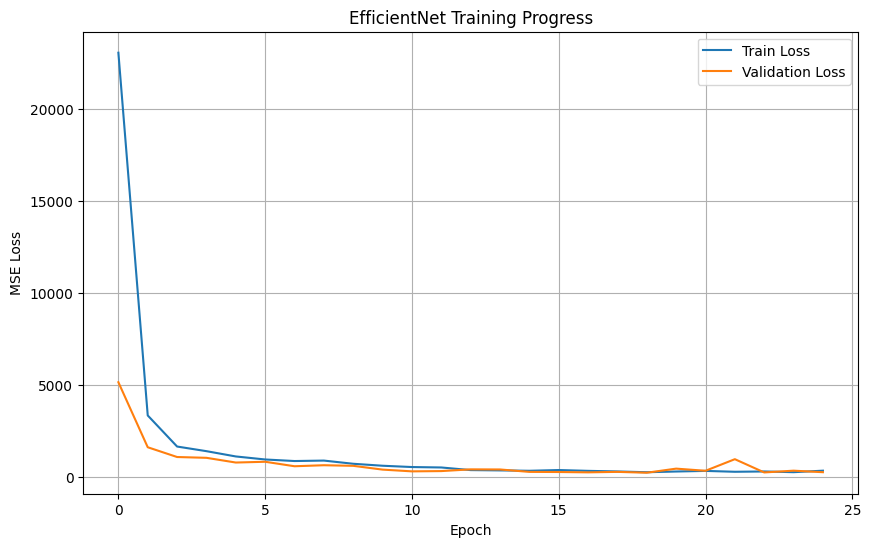

EfficientNet nowcasting training completed!


In [ ]:
def train_efficientnet_nowcasting():
    config = {
        'learning_rate': 1e-4,
        'batch_size': 64,
        'num_epochs': 25,
        'image_dirs': [
            '/content/drive/MyDrive/data/processed/2019_01_15',
            '/content/drive/MyDrive/data/processed/2019_01_16',
            '/content/drive/MyDrive/data/processed/2019_01_17',
            '/content/drive/MyDrive/data/processed/2019_01_18',
            '/content/drive/MyDrive/data/processed/2019_01_19',
            '/content/drive/MyDrive/data/processed/2019_01_20'

        ],
        'irradiance_files': [
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_15/pyranometer/2019_01_15.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_16/pyranometer/2019_01_16.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_17/pyranometer/2019_01_17.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_18/pyranometer/2019_01_18.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_19/pyranometer/2019_01_19.csv',
            '/content/drive/MyDrive/GIRASOL_DATASET/2019_01_20/pyranometer/2019_01_20.csv',

        ]
    }
    print("Loading multi-day dataset...")
    dataset = get_multi_day_dataset(config['image_dirs'], config['irradiance_files'])
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
    trainer = CNNTrainer(config=config)
    trainer.train(train_loader, val_loader)
    print("EfficientNet nowcasting training completed!")


train_efficientnet_nowcasting()